<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Project Outline
    
</div>

The overall goal of my project is to use deep learning to train a model for image caption generation. I am using a dataset of over eight thousand flickr8k images that have been created and tied to specific captions that detail what is going on in that image. Each image has 5 captions pertaining different ways to accurately describe each of the images. Data cleaning had to be done in order to make the data fit into a format to flow into the models. I first started off by using a pre trained VGG16 model to get sample edges and weights. Then after running some EDA I moved on to making my own LSTM (Long short-term memory) network for my recurrent neural network (RNN). My training process will include fine tuning the model with various hyperparameters. I also monitored my loss and validation loss over various epochs to help identify possible gaps of overfitting. Ideally these adjustments will lead to improvements in the caption generation that I make to accurately describe the images. I will be using the BLEU (Bilingual Evaludation Understudy) Score for evaluating my model and assisting with tuning my model.

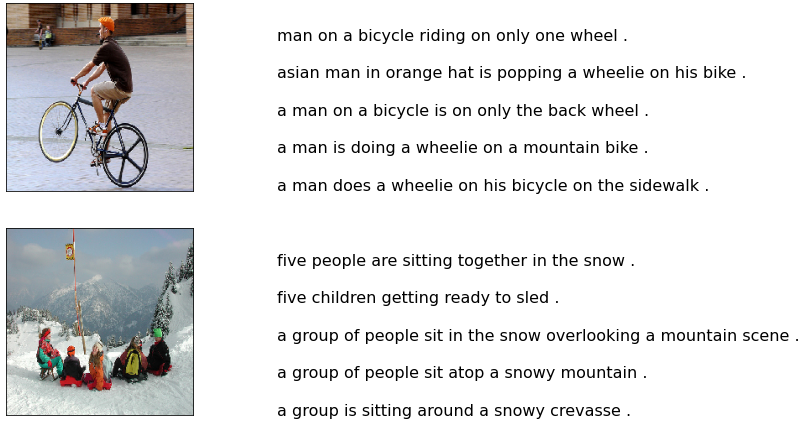


Citation: Kevin Vaghela. (2021). Flickr 8k Dataset. Version 1. Retrieved January 10th, 2024.

# Imports

In [1]:
import string
import numpy as np
import pandas as pd
from PIL import Image
from copy import copy
import tensorflow as tf
import matplotlib.pyplot as plt
import sys, os, warnings
from time import time
from collections import Counter, OrderedDict
from IPython.display import display
from sklearn.decomposition import PCA
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.compat.v1.keras.backend import set_session
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.applications import VGG16
from keras.utils import to_categorical
from keras.layers import Input, Dropout
from keras.callbacks import TensorBoard
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.advanced_activations import LeakyReLU, PReLU

# GPU Configuration

In [2]:
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf_config.gpu_options.visible_device_list = "0"
set_session(tf.compat.v1.Session(config=tf_config))

def set_seed(seed_value=8):
    seed(seed_value)
    rn.seed(seed_value)
    set_random_seed(seed_value)

flickr_images_dir = "../input/flickr/Images"
flickr_text_dir = "../input/flickr.token.txt"

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Data Inspection
    
</div>

Overall when doing my data inspection, I loaded in all of the image files, and then extracted samples of the text data. I constructed a data frame from that. I went on to see that each image has exactly 5 captions tied to that image relating to what is in the image. Then I went on to visually inspect some samples of the data to see a few images and their related captions.

**Load Image List:**
* Use os.listdir to get a list of all JPEG files in the specified directory (dir_Flickr_jpg).

**Read Text Data from Files:**
* Open the text file (dir_Flickr_text) and read its contents.
* Split the text into separate lines and process each line to extract relevant data.

**Construct DataFrame:**
* Iterate through each line of the text data.
* Split each line by tabs to separate different pieces of information.
* Construct a list (datatxt) containing the filename, index, and caption for each entry.
* Create a DataFrame (df_txt) from this list with columns ["filename", "index", "caption"].

**Data Inspection:**
* Print the total number of JPEG images found and the number of unique filenames.
* Print the first 5 rows of the DataFrame (df_txt) to inspect the data structure.
* Print rows 6 to 11 of the DataFrame for further inspection.

**Display Images and Captions:**
* Set parameters for image loading (npix, target_size).
* Iterate through the last 5 unique filenames (uni_filenames[-5:]).
* Load each image using load_img from keras.preprocessing.image.
* Create a subplot for each image and its captions using Matplotlib.
* Display the image and its associated captions in the subplot.

# Inspect Flickr8k Image Dataset

In [3]:
# Loads the image list
jpg_files = os.listdir(flickr_images_dir)

# Opens the image and reads the text from images
text_file = open(flickr_text_dir, 'r', encoding='utf8')
text_data = text_file.read()
text_file.close()

# Constructs the data into separate pieces for the dataframe
data_text = []
for line in text_data.split('\n'):
    columns = line.split('\t')
    if len(columns) == 1:
        continue
    words = columns[0].split("#")
    data_text.append(words + [columns[1].lower()])

df_text = pd.DataFrame(data_text, columns=["filename", "index", "caption"])
unique_filenames = np.unique(df_text.filename.values)

# Data inspection
print(f"Total Images Found: {len(jpg_files)} jpegs")
print(f"Unique File Names: {format(len(unique_filenames))} \n")
Counter(Counter(df_text.filename.values).values())
print(f"{df_text[0:5]}\n")
print(df_text[6:11])

Total Images Found: 8091 jpegs
Unique File Names: 8092 

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  

                     filename index  \
6   1001773457_577c3a7d70.jpg     1   
7   1001773457_577c3a7d70.jpg     2   
8   1001773457_577c3a7d70.jpg     3   
9   1001773457_577c3a7d70.jpg     4   
10  1002674143_1b742ab4b8.jpg     0   

                                              caption  
6   a black dog and a tri-colored dog playing with...  
7   a black dog and a white dog with

# Inspect Visual Data

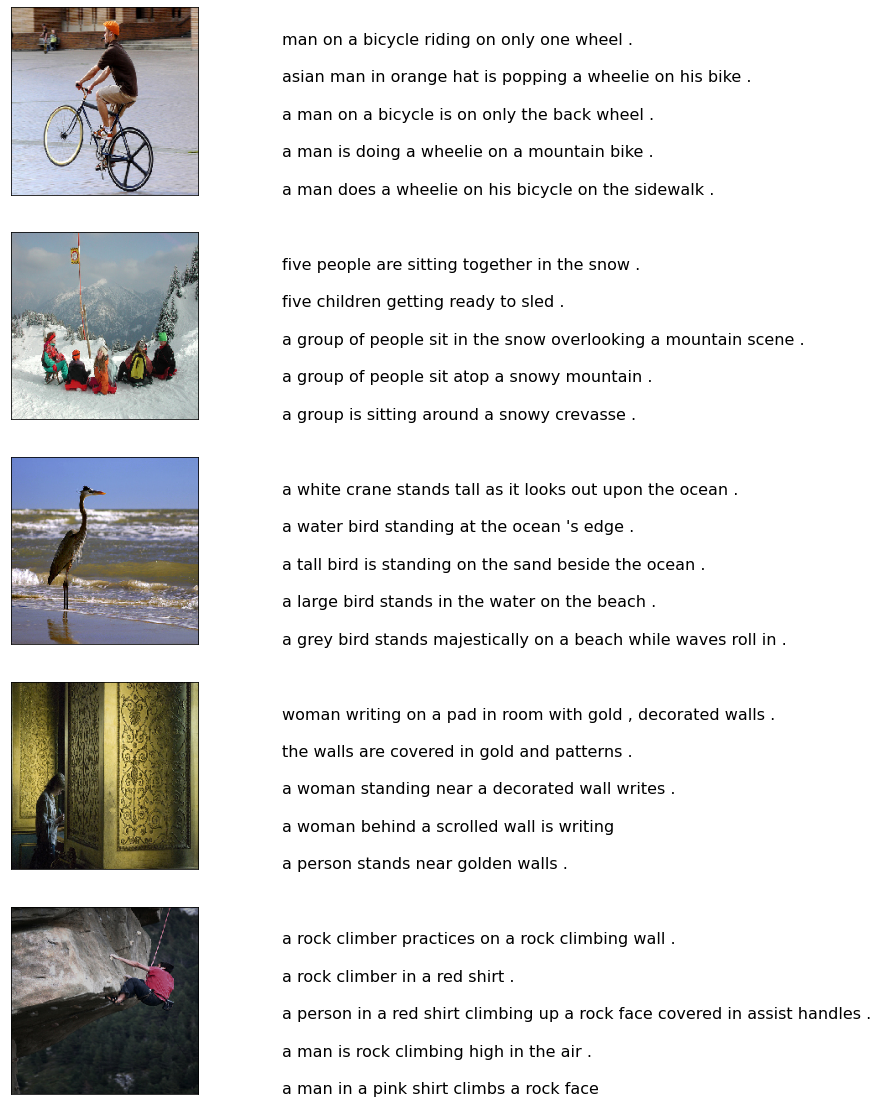

In [4]:
num_pics = 5
num_pixels = 224
target_img_size = (num_pixels, num_pixels, 3)

counter = 1
fig = plt.figure(figsize=(10, 20))

for jpg_filename in unique_filenames[-5:]:
    img_filename = flickr_images_dir + '/' + jpg_filename
    captions = list(df_text["caption"].loc[df_text["filename"] == jpg_filename].values)
    image_load = load_img(img_filename, target_size=target_img_size)

    ax = fig.add_subplot(num_pics, 2, counter, xticks=[], yticks=[])
    ax.imshow(image_load)
    counter += 1

    ax = fig.add_subplot(num_pics, 2, counter)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=16)
    counter += 1
plt.show()   

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Data Cleaning
    
</div>

Below I have outline all of the steps I have done to clean my data. This makes sure that each image with captions gets similar cleaning applied and will remove numeric characters, punctuation and singlecharacters prior to training the model.

**Remove Numeric Characters:**
* Iterate through each word in the text.
* Check if the word consists only of alphabetic characters.
* If it does, append the word to the cleaned text.
* Optionally, print whether each word is alphabetic or not.

**Remove Punctuation:**
* Utilize the translate method to remove all punctuation characters from the text.

**Remove Single Characters:**
* Iterate through each word in the text.
* Append words with a length greater than one to the cleaned text.

**Text Cleaning Function:**
* Combine the above steps into a single function text_clean.
* Apply remove_punctuation, removing_single_char, and remove_numeric functions sequentially to clean the text.

**Data Cleaning Loop:**
* Iterate through each caption in the DataFrame (df_txt).
* Clean each caption using the text_clean function.
* Update the DataFrame with the cleaned caption.

In [5]:
def remove_numbers(text, print_output=False):
    text_without_numbers = ""
    for word in text.split():
        is_alpha = word.isalpha()
        if print_output:
            print("     {:10} : {:}".format(word, is_alpha))
        if is_alpha:
            text_without_numbers += " " + word
    return text_without_numbers

def remove_punctuation(text_original):
    text_without_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    return text_without_punctuation

def remove_single_char(text):
    text_length_greater_than_one = ""
    for word in text.split():
        if len(word) > 1:
            text_length_greater_than_one += " " + word
    return text_length_greater_than_one

original_text = "I hope you score me at 100 percent for this project! Thanks for looking at my deep learning model."

text_without_numbers = remove_numbers(original_text, print_output=True)
text_without_punctuation = remove_punctuation(original_text)
text_length_greater_than_one = remove_single_char(original_text)

print("\nOriginal sentence with no modification: ", original_text)
print("Original sentence with numbers removed:", text_without_numbers)
print("Original sentence with punctuation removed:", text_without_punctuation)
print("Original sentence with single char removed:", text_length_greater_than_one)

# Cleans the data using previous methods
def clean_text(original_text):
    text = remove_punctuation(original_text)
    text = remove_single_char(text)
    text = remove_numbers(text)
    return text

for i, caption in enumerate(df_text.caption.values):
    new_caption = clean_text(caption)
    df_text['caption'].iloc[i] = new_caption

     I          : True
     hope       : True
     you        : True
     score      : True
     me         : True
     at         : True
     100        : False
     percent    : True
     for        : True
     this       : True
     project!   : False
     Thanks     : True
     for        : True
     looking    : True
     at         : True
     my         : True
     deep       : True
     learning   : True
     model.     : False

Original sentence with no modification:  I hope you score me at 100 percent for this project! Thanks for looking at my deep learning model.
Original sentence with numbers removed:  I hope you score me at percent for this Thanks for looking at my deep learning
Original sentence with punctuation removed: I hope you score me at 100 percent for this project Thanks for looking at my deep learning model
Original sentence with single char removed:  hope you score me at 100 percent for this project! Thanks for looking at my deep learning model.


<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Exploratory Data Analysis (EDA)
    
</div>

## Analyze Vocabulary Trends
The goal with the below methods was to analyze the textual data that is associated with each image inside the data frame. The df_word method goes through all of the captions in the data frame to make a vocabulary list containing individal words. Then it has a counter class to count the frequency of each word it sees in the captions. I then create a new data frame with two columns of word and count which is sorted by the frequency of that word. Then, using the next method, I plot two histograms to visually represent the frequency distribution of the top and bottom words. This will offer insights into the most and least common words inside of the captions.

In [ ]:
def create_word_dataframe(df_text):
    vocabulary = []
    for text in df_text.caption.values:
        vocabulary.extend(text.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    word_count = Counter(vocabulary)
    df_word_count = pd.DataFrame({'word': list(word_count.keys()), "count": list(word_count.values())})
    df_word_count = df_word_count.sort_values("count", ascending=False)
    df_word_count = df_word_count.reset_index()[["word", "count"]]
    
    return df_word_count

df_word_count = create_word_dataframe(df_text)
df_word_count.head()

top_words = 75

def plot_word_histogram(df_subset, title="Plotting top 75 words"):
    plt.figure(figsize=(20, 3))
    plt.bar(df_subset.index, df_subset["count"])
    plt.yticks(fontsize=18)
    plt.xticks(df_subset.index, df_subset["word"], rotation=90, fontsize=18)
    plt.title(title, fontsize=20)
    plt.show()

df_word_count = create_word_dataframe(df_text)
plot_word_histogram(df_word_count.iloc[:top_words, :], title="75 Most Appearing Words")
plot_word_histogram(df_word_count.iloc[-top_words:, :], title="75 Least Appearing Words")


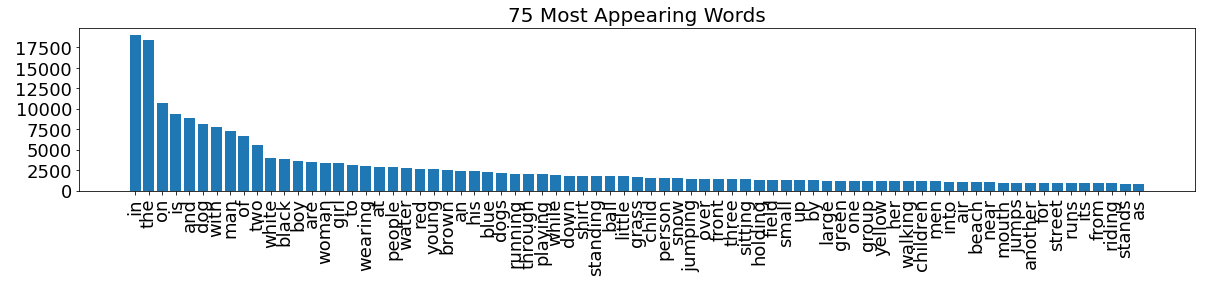

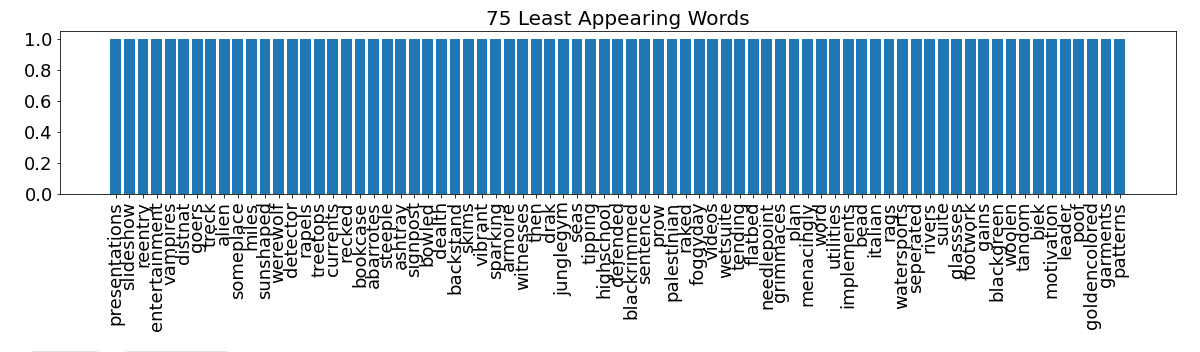

## Feature Extraction Part 1
The function defined below is made to modify the captions in the DataFrame. Each caption inside of the input list will go through the loop, it is then augmented with the 'startseq' at the beginning and 'endseq' at the end. This will encapsulate each caption with these special tokens. A new text dataframe is used to store the results. Then I display the first 10 rows in the new dataframe.

In [7]:
def add_start_end_tokens(captions):
    caps = []
    for text in captions:
        text = "startseq" + text + " endseq"
        caps.append(text)
    return caps

df_text_updated = copy(df_text)
df_text_updated["caption"] = add_start_end_tokens(df_text["caption"])
df_text_updated.head(10)

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   
5  1001773457_577c3a7d70.jpg     0   
6  1001773457_577c3a7d70.jpg     1   
7  1001773457_577c3a7d70.jpg     2   
8  1001773457_577c3a7d70.jpg     3   
9  1001773457_577c3a7d70.jpg     4   

                                             caption  
0  startseq child in pink dress is climbing up se...  
1    startseq girl going into wooden building endseq  
2  startseq little girl climbing into wooden play...  
3  startseq little girl climbing the stairs to he...  
4  startseq little girl in pink dress going into ...  
5  startseq black dog and spotted dog are fightin...  
6  startseq black dog and tricolored dog playing ...  
7  startseq black dog and white dog with brown sp...  
8  startseq two dogs of different breeds looking ...  
9  startseq two dogs on pavement moving toward ea...

## Loading VGG16 Model Weights
Initializes my VGG16 Model and Weights from Keras. Since include top is set to true, I have fully connected layers at the top of the network and I want those included. Then I load the weights of the model from my project directiory. This will contain my pre-trained wieghts from the model. Then I display the the summary of my VGG16 model.

In [8]:
model_vgg16 = VGG16(include_top=True, weights=None)
model_vgg16.load_weights("../input/vgg16-weights.h5")
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Trimming The Model Part 2
Creates a new Sequential model by going through the layers of my existing VGG16 model. It then adds them to the new model and excludes the last layer. It slices it using the -1 you see below. Then a new model is created with the exisiting layers of the previous. Then I display my summary to show the removed layer. The last layer is unneeded because it just specifies object classification.

In [9]:
model_seq = Sequential()
for layer in model_vgg16.layers[:-1]:
    model_seq.add(layer)
final_vgg_model = models.Model(inputs=model_seq.inputs, outputs=model_seq.layers[-1].output)

final_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Feature Extraction part 2
I created a dictionary containing the images. It stores the flattened feature vectors of the images.. The feature vectors are extracted using a pre-trained VGG16 model. The images are loaded from the jpgs list and resized to a fixed size of 224x224 pixels. This is required by the pretrained VGG16 model. Each image has preprocessing applied to prepare it for the model. It is then passed therough the final VGG model which outputs the feature vector

In [10]:
images_dict = OrderedDict()
num_pixels = 224
target_size = (num_pixels, num_pixels, 3)
data = np.zeros((len(jpg_files), num_pixels, num_pixels, 3))
for i, name in enumerate(jpg_files):
    filename = flickr_images_dir + '/' + name
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)
    preprocessed_image = preprocess_input(image)
    
    y_pred = final_vgg_model.predict(preprocessed_image.reshape((1,) + preprocessed_image.shape[:3]))
    images_dict[name] = y_pred.flatten()

## Finding Similar Images Using PCA
I used Principal Component Analysis to reduce the dimensionality of the image data in the dictionary. The encoder array is made by convertin the values of the images dictionary into an array. Then, the PCA is instantiated with 2 components since it is in a two-dimensional space. Then I applied the transform method to the encoder array to compute and apply the PCA transformation. This results in an array containing the reduced dimensional image representations. Then a set of specific images are selected and categorized into different colors based on the selected image dictionary. Each color category has a list of image indicies that dcorrespond to the selected images. They are used to annotate the PCA scatter plot where each point represents an image's reduced-dimensional representation. The images corresponding to the selected indices are plotted alongside their respective color categories. I create two different plots, one a scatter plot and one a set of images. The scatter plot displays the reduced-dimensional representations of the images obtained from the PCA. The set of images are plotted in a grid where each row represents a color category and each column is an individual image.

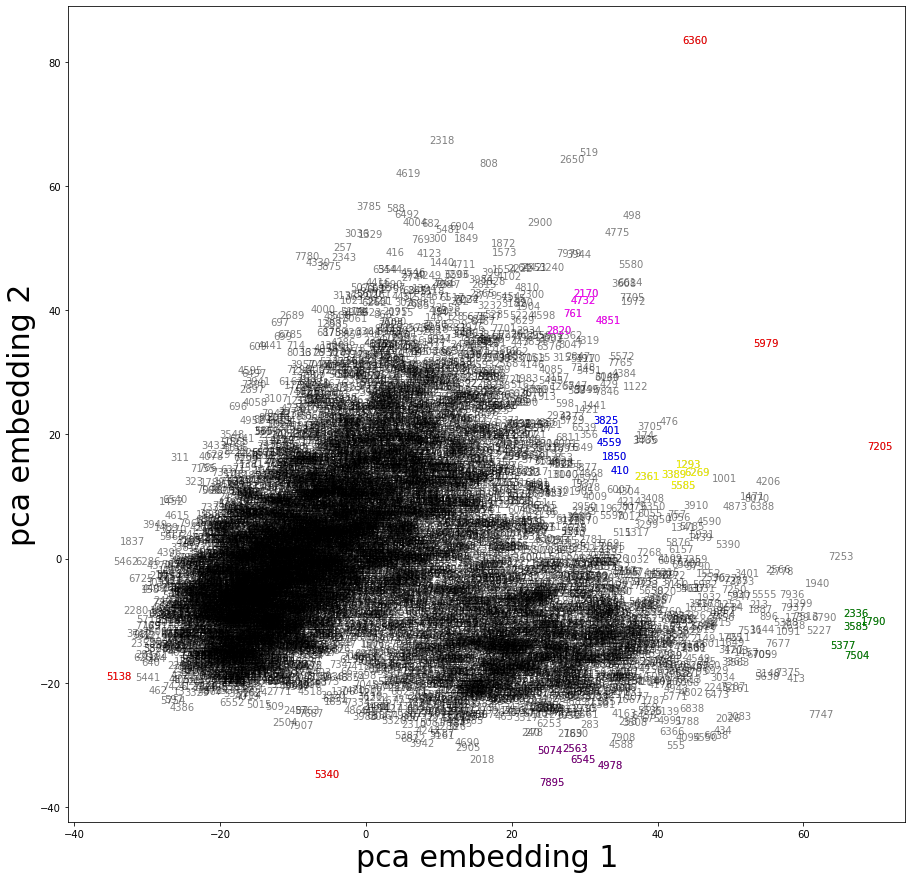

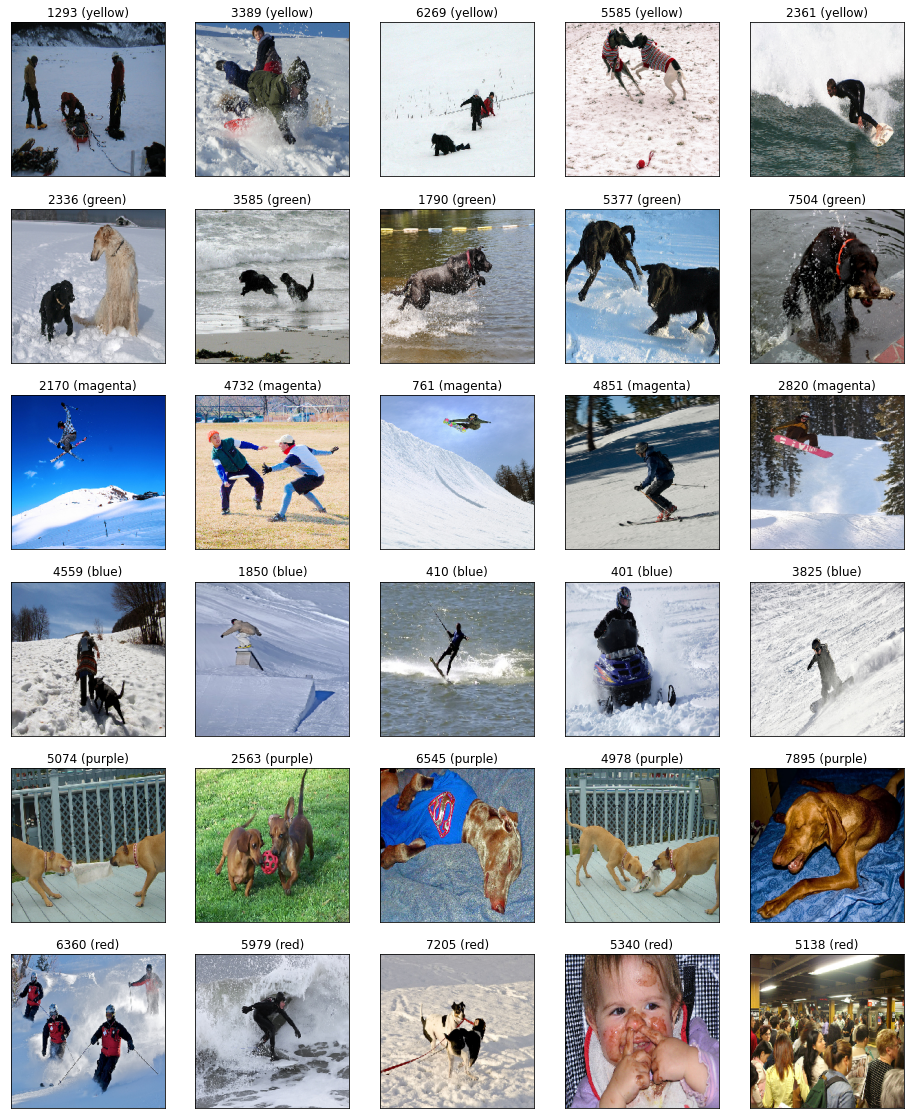

In [11]:
encoder = np.array(list(images_dict.values()))
pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)

selected_images = OrderedDict()
selected_images["yellow"] = [1293, 3389, 6269, 5585, 2361]
selected_images["green"] = [2336, 3585, 1790, 5377, 7504]
selected_images["magenta"] = [2170, 4732, 761, 4851, 2820]
selected_images["blue"] = [4559, 1850, 410, 401, 3825]
selected_images["purple"] = [5074, 2563, 6545, 4978, 7895]
selected_images["red"] = [6360, 5979, 7205, 5340, 5138]

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(y_pca[:, 0], y_pca[:, 1], c="white")

for i_row in range(y_pca.shape[0]):
    ax.annotate(i_row, y_pca[i_row, :], color="black", alpha=0.5)
for color, i_rows in selected_images.items():
    for i_row in i_rows:
        ax.annotate(i_row, y_pca[i_row, :], color=color)
ax.set_xlabel("pca embedding 1", fontsize=30)
ax.set_ylabel("pca embedding 2", fontsize=30)
plt.show()

## plot the images
fig = plt.figure(figsize=(16, 20))
counter = 1
for color, i_rows in selected_images.items():
    for i_vec in i_rows:
        name = jpg_files[i_vec]
        filename = flickr_images_dir + '/' + name
        image = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(len(selected_images), 5, counter, xticks=[], yticks=[])
        counter += 1
        plt.imshow(image)
        plt.title("{} ({})".format(i_vec, color))
plt.show()

## Joining Images/Captions
Two empty lists are initialized to store image data and their corresponding indicies. The data is filtered to retain rows where the value in the index column is equal to 0. The loop then iterates over the indices and filenames in the txt file. If the filename is found in the dictionary of images, the corresponding image data is appended to the images list and its index is appending to the index list. The resulting image is converted to an array.


In [12]:
selected_data_images, keep_indices = [], []
df_text_updated = df_text_updated.loc[df_text_updated["index"].values == '0', :]

for i, filename in enumerate(df_text_updated.filename):
    if filename in images_dict.keys():
        selected_data_images.append(images_dict[filename])
        keep_indices.append(i)
        
selected_filenames = df_text_updated["filename"].iloc[keep_indices].values
selected_captions = df_text_updated["caption"].iloc[keep_indices].values
selected_data_images = np.array(selected_data_images)

df_text_updated.head()

filename index  \
0   1000268201_693b08cb0e.jpg     0   
5   1001773457_577c3a7d70.jpg     0   
10  1002674143_1b742ab4b8.jpg     0   
15  1003163366_44323f5815.jpg     0   
20  1007129816_e794419615.jpg     0   

                                              caption  
0   startseq child in pink dress is climbing up se...  
5   startseq black dog and spotted dog are fightin...  
10  startseq little girl covered in paint sits in ...  
15  startseq man lays on bench while his dog sits ...  
20  startseq man in an orange hat starring at some...

## Tokenizer and Data Splitting
The data is further preprocessed by splitting for training, validation and testing. A tokenizer object is created with a specified maximum number of words. It is then fitted on a list of caption to make a vocabulary of words. The size of the vocabulary is calculated by adding one to the length of the tokenizers word index. The captions are then converted into sequences of ints. The length of the data is calculated and based on the proportions. The data is split into three sets for test, validation and training data. The data is then slices.The min and max lengths of captions in the dataset are determined then.

In [13]:
num_words = 6000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(selected_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Size of the Vocabulary: {}".format(vocab_size))
tokenized_texts = tokenizer.texts_to_sequences(selected_captions)
print(tokenized_texts[:3])

test_prop, val_prop = 0.2, 0.2 

N = len(tokenized_texts)
N_test, N_val = int(N * test_prop), int(N * val_prop)

def split_test_val_train(texts, N_test, N_val):
    return (texts[:N_test], 
            texts[N_test:N_test + N_val],  
            texts[N_test + N_val:])

texts_test, texts_val, texts_train = split_test_val_train(tokenized_texts, N_test, N_val)
images_test, images_val, images_train = split_test_val_train(selected_data_images, N_test, N_val)
filenames_test, filenames_val, filenames_train = split_test_val_train(selected_filenames, N_test, N_val)

max_caption_length = np.max([len(text) for text in tokenized_texts])
min_caption_length = np.min([len(text) for text in tokenized_texts])
print("Min Caption Length: {} and Max Caption Length: {}".format(min_caption_length, max_caption_length))

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Size of the Vocabulary: 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2]]
Min Caption Length: 2 and Max Caption Length: 30


## Preprocessing the Image/Text Data
I created a preprocessing function that prepares the textual and image data for training the model. It takes in 2 lists. One for the images and one for the texts. It ensures that the lengths of both lists are the same using an assertion. Next, it goes through each pair of image/text combination and tokenizes the text into sequences and pads them to a fixed length. It also converts the output text into one-hot encoded vectors and then organizes the processed data into three arrays. These represent the text sequences, image features and output text sequences.The function is called twice to preprocess training and validation data. 

In [14]:
def preprocess_data(texts, images):
    N = len(texts)
    print("Captions Vs Images = {}".format(N))

    assert(N == len(images))  # using assert to ensure that the length of images and captions are always similar
    X_text, X_image, y_text = [], [], []
    for text, image in zip(texts, images):
        for i in range(1, len(text)):
            input_text, output_text = text[:i], text[i]
            input_text = pad_sequences([input_text], maxlen=max_caption_length).flatten() # using pad sequence to make the length of all captions equal
            output_text = to_categorical(output_text, num_classes=vocab_size) # using to_categorical to 

            X_text.append(input_text)
            X_image.append(image)
            y_text.append(output_text)

    X_text = np.array(X_text)
    X_image = np.array(X_image)
    y_text = np.array(y_text)
    print(" {} {} {}".format(X_text.shape, X_image.shape, y_text.shape))
    return (X_text, X_image, y_text)

X_text_train, X_image_train, y_text_train = preprocess_data(texts_train, images_train)
X_text_val, X_image_val, y_text_val = preprocess_data(texts_val, images_val)

Captions Vs Images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
Captions Vs Images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Model Architecture
    
</div>

Below I define my architecture for my neural network model. It incorporates both image and text data for join representation learning. It starts by processing image inputs through a full connected layer. This is used to extract features while the text inputs are put through embedding and LSTM layers to capture sequential information. The extracted features from both modalities are then combined and processed even more through an additional LSTM and dense layers to generate the predictions. The resulting model is compiled with categorical cross-entropy loss and Adam optimizer before it is trained on the data set for 6 epochs. During the training, I used various validation methods to tune the model. The training history including things like loss and validation loss over epochs is then visualized. The resulting model provides a great way to learn meaningful representations of image-text pairs to predict the next word for the captions.

**Input Layers:**
* Two input layers are defined: one for image data with a shape determined by Ximage_train.shape[1], and the other for text data with a maximum length specified by maxlen.

**Image Feature Extraction:**
* The image input is processed through a fully connected layer with 256 units and ReLU activation, labeled "ImageFeature".

**Text Feature Extraction:**
* The text input is first passed through an embedding layer, mapping word indices to dense vectors of size 64 with masking applied to ignore padding values.
* Subsequently, an LSTM layer with 256 units is applied to the embedded text data, returning sequences, and named "CaptionFeature".

**Decoder:**
* Dropout regularization is applied to the LSTM output with a dropout rate of 0.04.
* Another LSTM layer with 256 units, labeled "CaptionFeature2", is applied to the output of the previous LSTM layer.
* Features extracted from the text and image inputs are combined using element-wise addition.
* A fully connected layer with 256 units and ReLU activation is added to the decoder output.
* The final output layer predicts the next word in the sequence with vocab_size units and softmax activation.

**Model Compilation:**
* The model is compiled using categorical cross-entropy loss and the Adam optimizer.

**Model Training:**
* The model is trained using the training data (Ximage_train, Xtext_train, ytext_train) for 6 epochs with a batch size of 32.
* Validation data (Ximage_val, Xtext_val, ytext_val) is used to monitor the model's performance during training.

**Visualization:**
* Training history, including loss and validation loss, is visualized over epochs using Matplotlib.

## LSTM Model Creation
Firstly I print out the vocabulary size. Then I set the dimensionality of the model to be 64. Then I create two input layers. One is for the image data. This expects an input image with a shape determined by the image train shape. The other is for text data. For the image input, I construct a fully connected layer with 256 units and ReLU activation. For the text input, I embed layer maps word indices to dense vectors of size dim_embedding with masking applied to ignore padding values. This is then followed by an LSTM layer with 256 units. I use the features extracted from the text and image inputs to combine them. A fully connected layer with 256 units and ReLU activation is added to the decoder output. Lastly the output layer predicts the next word in the sequence. It uses the vocab size as the units and softmax activation. The LSTM model is compiled using categorical cross-entropy loss and the Adam optimizer.

In [15]:
print(vocab_size)

embedding_dimension = 64

input_image = Input(shape=(X_image_train.shape[1],))
image_features = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)
## sequence model
input_text = Input(shape=(max_caption_length,))
text_features = layers.Embedding(vocab_size, embedding_dimension, mask_zero=True)(input_text)
text_features = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(text_features)

dropout_layer = Dropout(0.04)(text_features)
text_features = layers.LSTM(256, name="CaptionFeature2")(dropout_layer)
# combining model for decoder

decoder_output = layers.add([text_features, image_features])
decoder_output = layers.Dense(256, activation="relu")(decoder_output)
output = layers.Dense(vocab_size, activation='softmax')(decoder_output)
model = models.Model(inputs=[input_image, input_text], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

4476
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 256)      0           CaptionFeature[0][0]             
_______________________________________________________________________________________

## LSTM Model Training
Below I train my Long Short-Term Memory model. This is a type of recurrent neural network that allows my to utilize both image and text data. I set up a Tensor Board callback. This allows me to visualize various metrics during the training process. The callback itself is configured to log the training progress into a directory that has the current timestamp. This allows me to track and analyze my progress easier. I train my model using the fit method. It learns from the input data with all of the images and their corresponding captions. I train the model over 6 epochs with a batch size of 32 then monitor the performance. Also the tensor board callback is included to allow for visual insights into the models behavior and performance. Lastly the training history for metrics like loss and accuracy is stored in the hist variable to plot later.

In [16]:
tensorboard = TensorBoard(log_dir="log/{}".format(time()))
history = model.fit([X_image_train, X_text_train], y_text_train, epochs=6, verbose=2, batch_size=32, validation_data=([X_image_val, X_text_val], y_text_val), callbacks=[tensorboard])

Epoch 1/6
1551/1551 - 380s - loss: 5.3601 - val_loss: 4.8343
Epoch 2/6
1551/1551 - 364s - loss: 4.4939 - val_loss: 4.5624
Epoch 3/6
1551/1551 - 364s - loss: 4.1029 - val_loss: 4.4839
Epoch 4/6
1551/1551 - 369s - loss: 3.8430 - val_loss: 4.5342
Epoch 5/6
1551/1551 - 366s - loss: 3.6444 - val_loss: 4.5762
Epoch 6/6
1551/1551 - 372s - loss: 3.4772 - val_loss: 4.6096


## LSTM Model Metrics
Creates visualization of the training and validation loss over the course of the various epochs. It then goes through a list of labels containing the loss and val_loss to plot the corresponding data from the history. Then I plot the loss values against the number of epochs to illustrate the models performance in terms of minimizing loss. This plots allows me to see the training dynamics and convergence of the model while training.

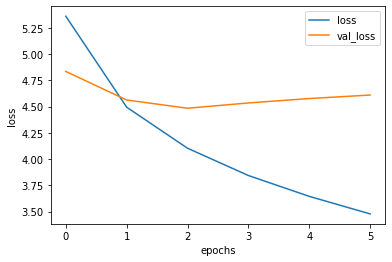

In [17]:
for label in ["loss","val_loss"]:
    plt.plot(history.history[label], label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Results
    
</div>

Below I outline the process for how I used my final model and came up with my final results for this project. After testing on a subset of data and determining that my model was providing accurate information, I moved on to testing it on the entire test image dataset. I calculated the BLEU score score of my predicitions versus the original caption and then classified the prediction as either strong or weak. Then I displayed the results below of the strong image and caption combos and the weak image and caption combos.

**Caption Generation:**
* The predict_caption function generates captions for a set of test images using a trained model and tokenizer. It iterates over the maximum length of the caption, predicting each word and appending it to the caption until the "endseq" token is encountered.

**Visualization of Predicted Captions:**
* For a subset of test images, the code loads each image, generates a caption using predict_caption, and visualizes the image alongside the predicted caption. This provides an overview of the model's performance in generating captions for the test images.

**BLEU Score Calculation:**
* BLEU scores are computed for two hypotheses compared to a reference sentence. The hypotheses and reference sentences are split into lists of individual words, and BLEU scores are calculated using the sentence_bleu function from the NLTK library. This evaluates the similarity between the generated hypotheses and the reference sentence based on the BLEU metric.

**Evaluation of Predicted Captions:**
* The code iterates over test images, generates captions using predict_caption, calculates BLEU scores for each generated caption compared to the corresponding true caption, and categorizes the captions as strong or weak based on their BLEU scores.

**Visualization of Strong and Weak Captions:**
* The plot_images function visualizes strong and weak captions alongside their corresponding images. It displays the true and predicted captions, as well as their BLEU scores, providing insights into the quality of captions generated for the test images.

## Testing Model on Subset of Data
Firstly with the predict_caption method, I can generate captions with my model that I am predicting. It takes an image as an input and then iteratively predicts the next word in the caption until it hits the endseq token or reaches the max length. It uses my traine model and a tokenizer to convert the text to sequences and then sequences to text. Lastly the method will use an index_word dictionary to map the indices to words based on the tokenizers word index. Below, I use my predict caption method to test a sample of the image data to see how the model is performing. For each image, the loop generates a caption by prediciting words based on the features of that image. Then it displays them.

In [ ]:
word_index_map = dict([(index, word) for word, index in tokenizer.word_index.items()])

def generate_caption(image):
    current_text = 'startToken'
    
    for i in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([current_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        y_hat = model.predict([image, sequence], verbose=0)
        predicted_index = np.argmax(y_hat)
        new_word = word_index_map[predicted_index]
        current_text += " " + new_word
        if new_word == "endToken":
            break
            
    return current_text

num_images_to_plot = 5
image_size = 224
target_image_size = (image_size, image_size, 3)
subplot_count = 1

figure = plt.figure(figsize=(10, 20))

for file_name, image_feature in zip(filenames_test[15:20], images_test[15:20]):
    # Load images
    image_path = flickr_images_dir + '/' + file_name
    loaded_image = load_image(image_path, target_size=target_image_size)
    axis = figure.add_subplot(num_images_to_plot, 2, subplot_count, xticks=[], yticks=[])
    axis.imshow(loaded_image)
    subplot_count += 1
    
    # Generate captions
    predicted_caption = generate_caption(image_feature.reshape(1, len(image_feature)))
    axis = figure.add_subplot(num_images_to_plot, 2, subplot_count)
    plt.axis('off')
    axis.plot()
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.text(0, 0.5, predicted_caption, fontsize=20)
    subplot_count += 1
    
plt.show()

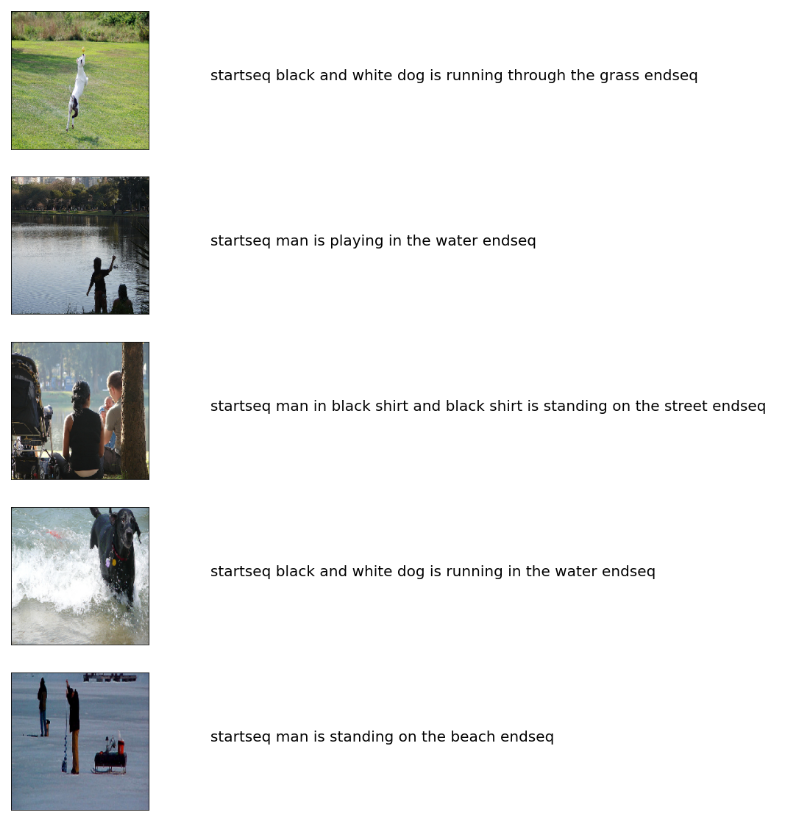

## Sample of BLEU Scoring
Below I provide an example of how I will be scoring my model. I will be using the BLEU (Bilingual Evaluation Understudy) score. I demo how that works below. I have two sample hypothesis that are my 'prediction' of the reference string. I split each string into a list of words. Then I use the BLEU score to determine how closely they match to the reference sentence.

In [19]:
first_hypothesis = "I enjoy deep learning!"
second_hypothesis = "I'm crazy about deep learning!"
reference_sentence = "I really enjoy deep learning!"

first_hypothesis_words = first_hypothesis.split()
second_hypothesis_words = second_hypothesis.split()
reference_sentence_words = [reference_sentence.split()]

print("BLUE Score 1: {:4.3f}".format(sentence_bleu(reference_sentence_words, first_hypothesis_words)))
print("BLUE Score 2: {:4.3f}".format(sentence_bleu(reference_sentence_words, second_hypothesis_words)))

BLUE Score 1: 0.592
BLEU Score 2: 0.562


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## Calculate BLEU Score on Entire Test Dataset with Caption Predictions
Firstly I create a dictionary to map the indicies to words based on the tokenizers word index. Then I loop through the test images along with their corresponding features and captions. I removed the starting and ending tokens from the caption. Then use my predict_caption method to generate a tokenized caption for the image. I then compared the outputted caption to the original to determine the BLEU score. If the score is above 0.7, then I classify that prediction as strong. And if it is below 0.3 then I classify that prediction as weak. Then lastly I display the mean BLEU score across the entire dataset.

In [20]:
index_to_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

n_keep = 5
strong_predictions, weak_predictions, bleu_scores = [], [], []
counter = 0

for file_name, image_feat, tokenized_text in zip(filenames_test, images_test, texts_test):
    counter += 1
    if counter % 200 == 0:
        print("{:4.2f}% completed.".format(100*counter/float(len(filenames_test))))

    true_caption = [index_to_word[i] for i in tokenized_text]
    true_caption = true_caption[1:-1]

    predicted_caption = generate_caption(image_feat.reshape(1, len(image_feat)))
    predicted_caption = predicted_caption.split()
    predicted_caption = predicted_caption[1:-1]

    bleu_score = sentence_bleu([true_caption], predicted_caption)
    bleu_scores.append(bleu_score)

    if bleu_score > 0.7 and len(strong_predictions) < n_keep:
        strong_predictions.append((bleu_score, file_name, true_caption, predicted_caption))
    elif bleu_score < 0.3 and len(weak_predictions) < n_keep:
        weak_predictions.append((bleu_score, file_name, true_caption, predicted_caption))

print("The mean BLEU score is: {:4.3f}".format(np.mean(bleu_scores)))

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


12.36% completed.
24.72% completed.
37.08% completed.
49.44% completed.
61.80% completed.
74.17% completed.
86.53% completed.
98.89% completed.
The mean BLEU score is: 0.381


## Examples of Good/Bad Predictions
The below method plot_images is used to visually compare the strong and weak captions I just generated above. It takes a list of captions as input. For each caption it extracts the relevant info like the BLEU score, filename and the true caption and then displays the result. The captions are formatted into strings and the BLEU score is displayed. This process is repeated for both the strong and weak captions. The output is displayed below.

Strong Predictions


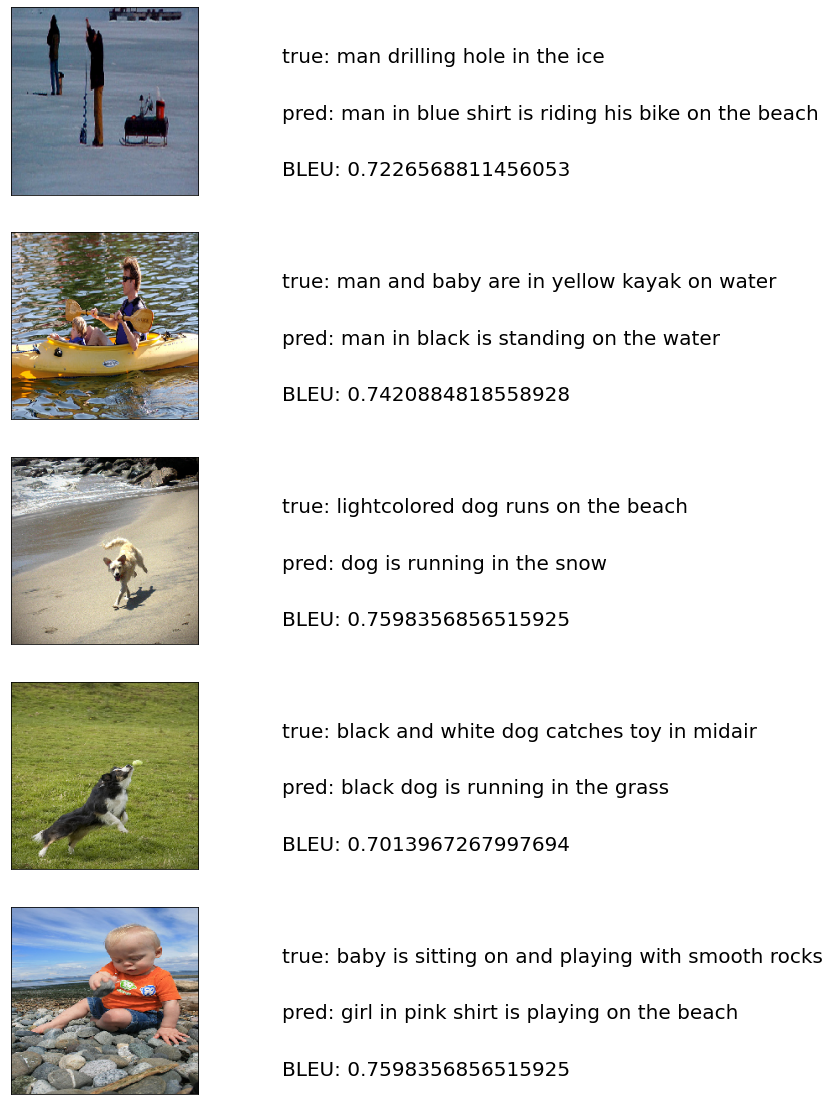

Weak Predictions


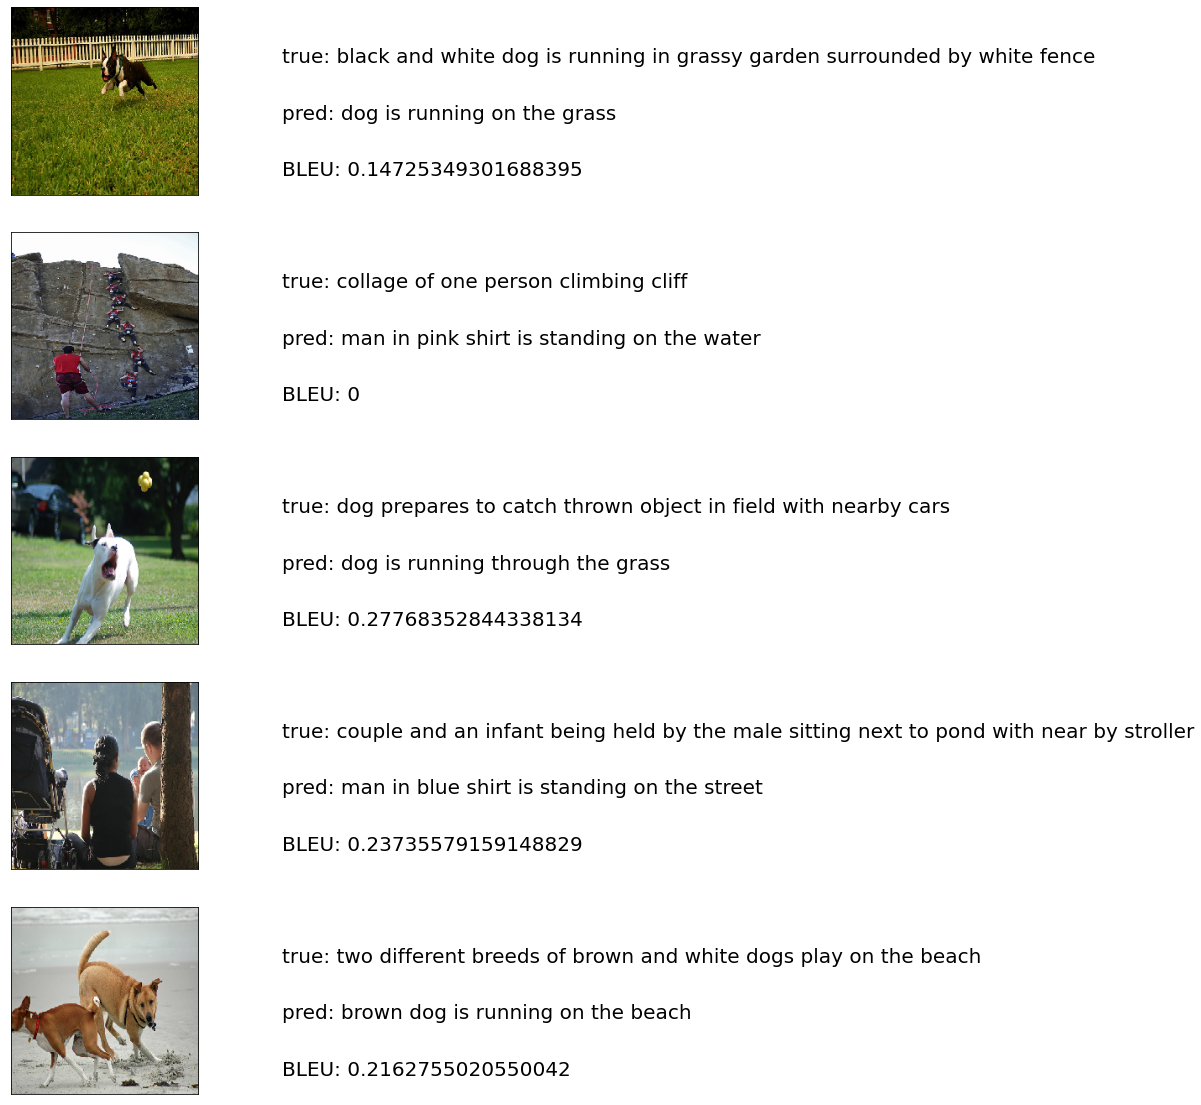

In [21]:
def plot_image_predictions(predictions):
    def create_caption_string(true_caption):
        caption_str = ""
        for word in true_caption:
            caption_str += " " + word
        return caption_str

    npixels = 224
    target_size = (npixels, npixels, 3)
    counter = 1
    figure = plt.figure(figsize=(10, 20))
    num_images = len(predictions)

    for prediction in predictions:
        bleu_score, file_name, true_caption, predicted_caption = prediction

        image_file = flickr_images_dir + '/' + file_name
        loaded_image = load_image(image_file, target_size=target_size)

        ax = figure.add_subplot(num_images, 2, counter, xticks=[], yticks=[])
        ax.imshow(loaded_image)
        counter += 1

        true_caption_str = create_caption_string(true_caption)
        predicted_caption_str = create_caption_string(predicted_caption)

        ax = figure.add_subplot(num_images, 2, counter)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.text(0, 0.7, "True Caption:" + true_caption_str, fontsize=20)
        ax.text(0, 0.4, "Predicted Caption:" + predicted_caption_str, fontsize=20)
        ax.text(0, 0.1, "BLEU Score: {}".format(bleu_score), fontsize=20)
        counter += 1

    plt.show()

print("Strong Predictions")
plot_image_predictions(strong_predictions)
print("Weak Predictions")
plot_image_predictions(weak_predictions)

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Conclusion
    
</div>

<ins>What I Learned / Key Takeaway</ins>\
I feel like I was really able to use all of my previous knowledge I have gained in my past machine learning courses to use it in this final project for image caption generation. As always, hyperparameter tuning is super important in fine tuning the model. By doing this with different hyperparameters, the quality of the captions I generated was significantly improved over time while I was testing it. I also learned how that the higher the BLEU scores, the close the similarity there will be between the original and the prediction.

<ins>What Didn't Work</ins>\
Although I did use a lot of tuning with various hyperparameters, there were still some issues I faced. I ran into a lot of overfitting during this project. The validation loss started to increase after the 5th epoch while the training loss would continue to decrease. I believe this was because the model might of been focusing too much on the training data resulting in poor generalization to unseen data. I had to come up with ways to address this issue in order to perfect the model to the best I could.

<ins>Ways To Improve</ins>\
While working on the overfitting issues, I found a few ways to enhance the performance of my model. Firstly, I I could incorporate regularization techniques like L2 regularization or dropout during the training data to prevent some of the overfitting that I was seeing. This would make it so the model wasnt too focused on specific features or patterns in the training data. Next, I could increase the diversity and size of the training dataset. That way it could have a more broad range of examples to train off of. Lastly, I could add different architectures or pre trained models to further enhance the model that might be less error prone to ovefitting.